# **References**


* https://www.tensorflow.org/tutorials/images/segmentation
* https://www.kaggle.com/code/rajkumarl/get-started-with-semantic-segmentation

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **GPU Check**

In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

2024-05-06 15:52:31.463948: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 15:52:31.464056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 15:52:31.608033: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


# **Import Necessary Libraries**

In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import glob

# **Input Directories (Dataset)**

In [4]:
image_paths=sorted(glob.glob('/kaggle/input/fydp-u-net-model-dataset/FYDP_U_NET/images/*.png'))
mask_paths=sorted(glob.glob('/kaggle/input/fydp-u-net-model-dataset/FYDP_U_NET/annotations/*.png'))

# **Load data (Images & Masks)**

In [5]:
@tf.function
def load_image(image_path):
    file = tf.io.read_file(image_path)
    image = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
    return image

def load_mask(mask_path):
    file = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(file, channels=1, dtype=tf.uint8)
    return mask

images = [load_image(image_path) for image_path in image_paths]
masks = [load_mask(mask_path) for mask_path in mask_paths]
print(len(images), len(masks))

2167 2167


# **Visualize few images**

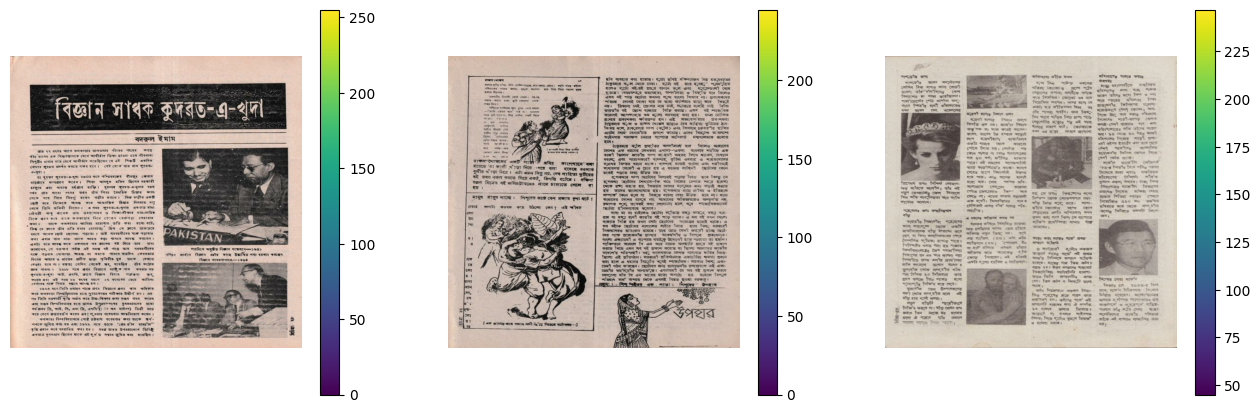

In [6]:
%matplotlib inline

plt.figure(figsize=(16, 5))
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.imshow(images[i])
    plt.colorbar()
    plt.axis('off')
plt.show()

# **Visualize corresponding masks**

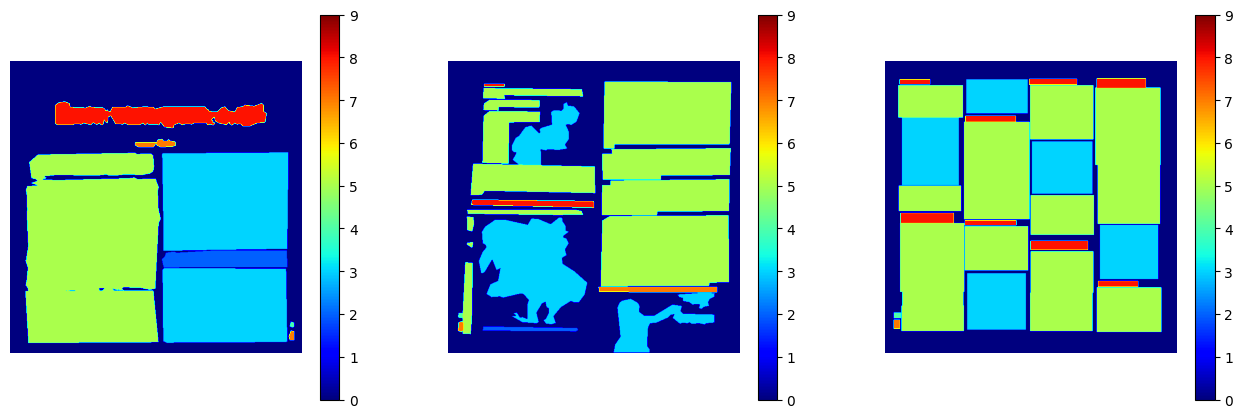

In [7]:
NORM = mpl.colors.Normalize(vmin=0, vmax=9)

plt.figure(figsize=(16, 5))
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.imshow(masks[i], cmap='jet', norm=NORM) 
    plt.colorbar()
    plt.axis('off')
plt.show()

# **Data Resizing according to the Model**

In [8]:
def resize_and_normalize_image(image):
    image = tf.cast(image, tf.float32)/255.0
    image = tf.image.resize(image, (128, 128))
    return image

def resize_mask(mask):
    mask = tf.image.resize(mask, (128, 128))
    mask = tf.cast(mask, tf.uint8)
    return mask

X = [resize_and_normalize_image(image) for image in images]
y = [resize_mask(mask) for mask in masks]
print(len(X), len(y))

2167 2167


# **Visualize a resized image and corresponding mask**

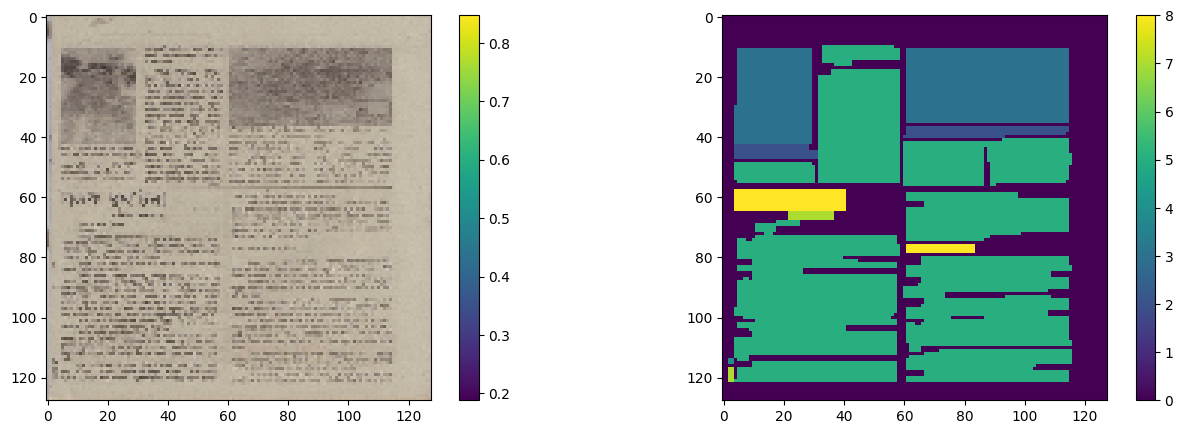

In [9]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.imshow(X[642])
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(y[642])
plt.colorbar()
plt.show()

# **Split Dataset for train and test set (80:20)**

In [10]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=16)

In [11]:
print(len(train_X), len(train_y), len(test_X), len(test_y))

1733 1733 434 434


# **Data Augmentation**

In [12]:
# adjust brigtness of image, don't alter in mask
def brigtness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# adjust hue of image, don't alter in mask
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

# crop both image and mask identically
def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    mask = tf.image.central_crop(mask, 0.7)
    img = tf.image.resize(img, (128, 128))
    mask = tf.image.resize(mask, (128, 128))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

 # flip both image and mask identically
def flip_horizontal(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

# flip both image and mask identically
def flip_vertical(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

# rotate both image and mask identically
def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

# **Data Preprocessing**

In [13]:
def preprocessing_data(train_X, test_X, train_y, test_y, BATCH_SIZE=64, BUFFER_SIZE=1000):
    train_X = tf.data.Dataset.from_tensor_slices(train_X.copy())
    test_X = tf.data.Dataset.from_tensor_slices(test_X.copy())
    train_y = tf.data.Dataset.from_tensor_slices(train_y.copy())
    test_y = tf.data.Dataset.from_tensor_slices(test_y.copy())

    train = tf.data.Dataset.zip((train_X, train_y))
    test = tf.data.Dataset.zip((test_X, test_y))
    
    # Perform augmentation on train data only
    a = train.map(brigtness)
    b = train.map(hue)
    c = train.map(crop)
    d = train.map(flip_horizontal)
    e = train.map(flip_vertical)
    f = train.map(rotate)
    
    # Concatenate every new augmented data
    for aug_data in [a, b, c, d, e, f]:
        train = train.concatenate(aug_data)
        
    # shuffle and group the train set into batches
    train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    # do a prefetch to optimize processing
    
    train = train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    # group the test set into batches
    
    test = test.batch(BATCH_SIZE)
    return train, test

train, test = preprocessing_data(train_X, test_X, train_y, test_y)

# **Define the Model**

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—MobileNetV2—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the pix2pix example in the TensorFlow Examples repo. (Check out the pix2pix: Image-to-image translation with a conditional GAN tutorial in a notebook.)

As mentioned, the encoder is a pretrained MobileNetV2 model. You will use the model from tf.keras.applications. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Clone Tensorflow Example Git Repo**

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

Build the upstack using an upsampling template. Let's use pix2pix template available open-source in `tensorflow_examples` repository

In [15]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [16]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

# **Build a U-Net model by merging downstack and upstack with skip-connections.**

In [17]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# **Train the model**

In [18]:
OUTPUT_CLASSES = 9

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# **Plot our model**

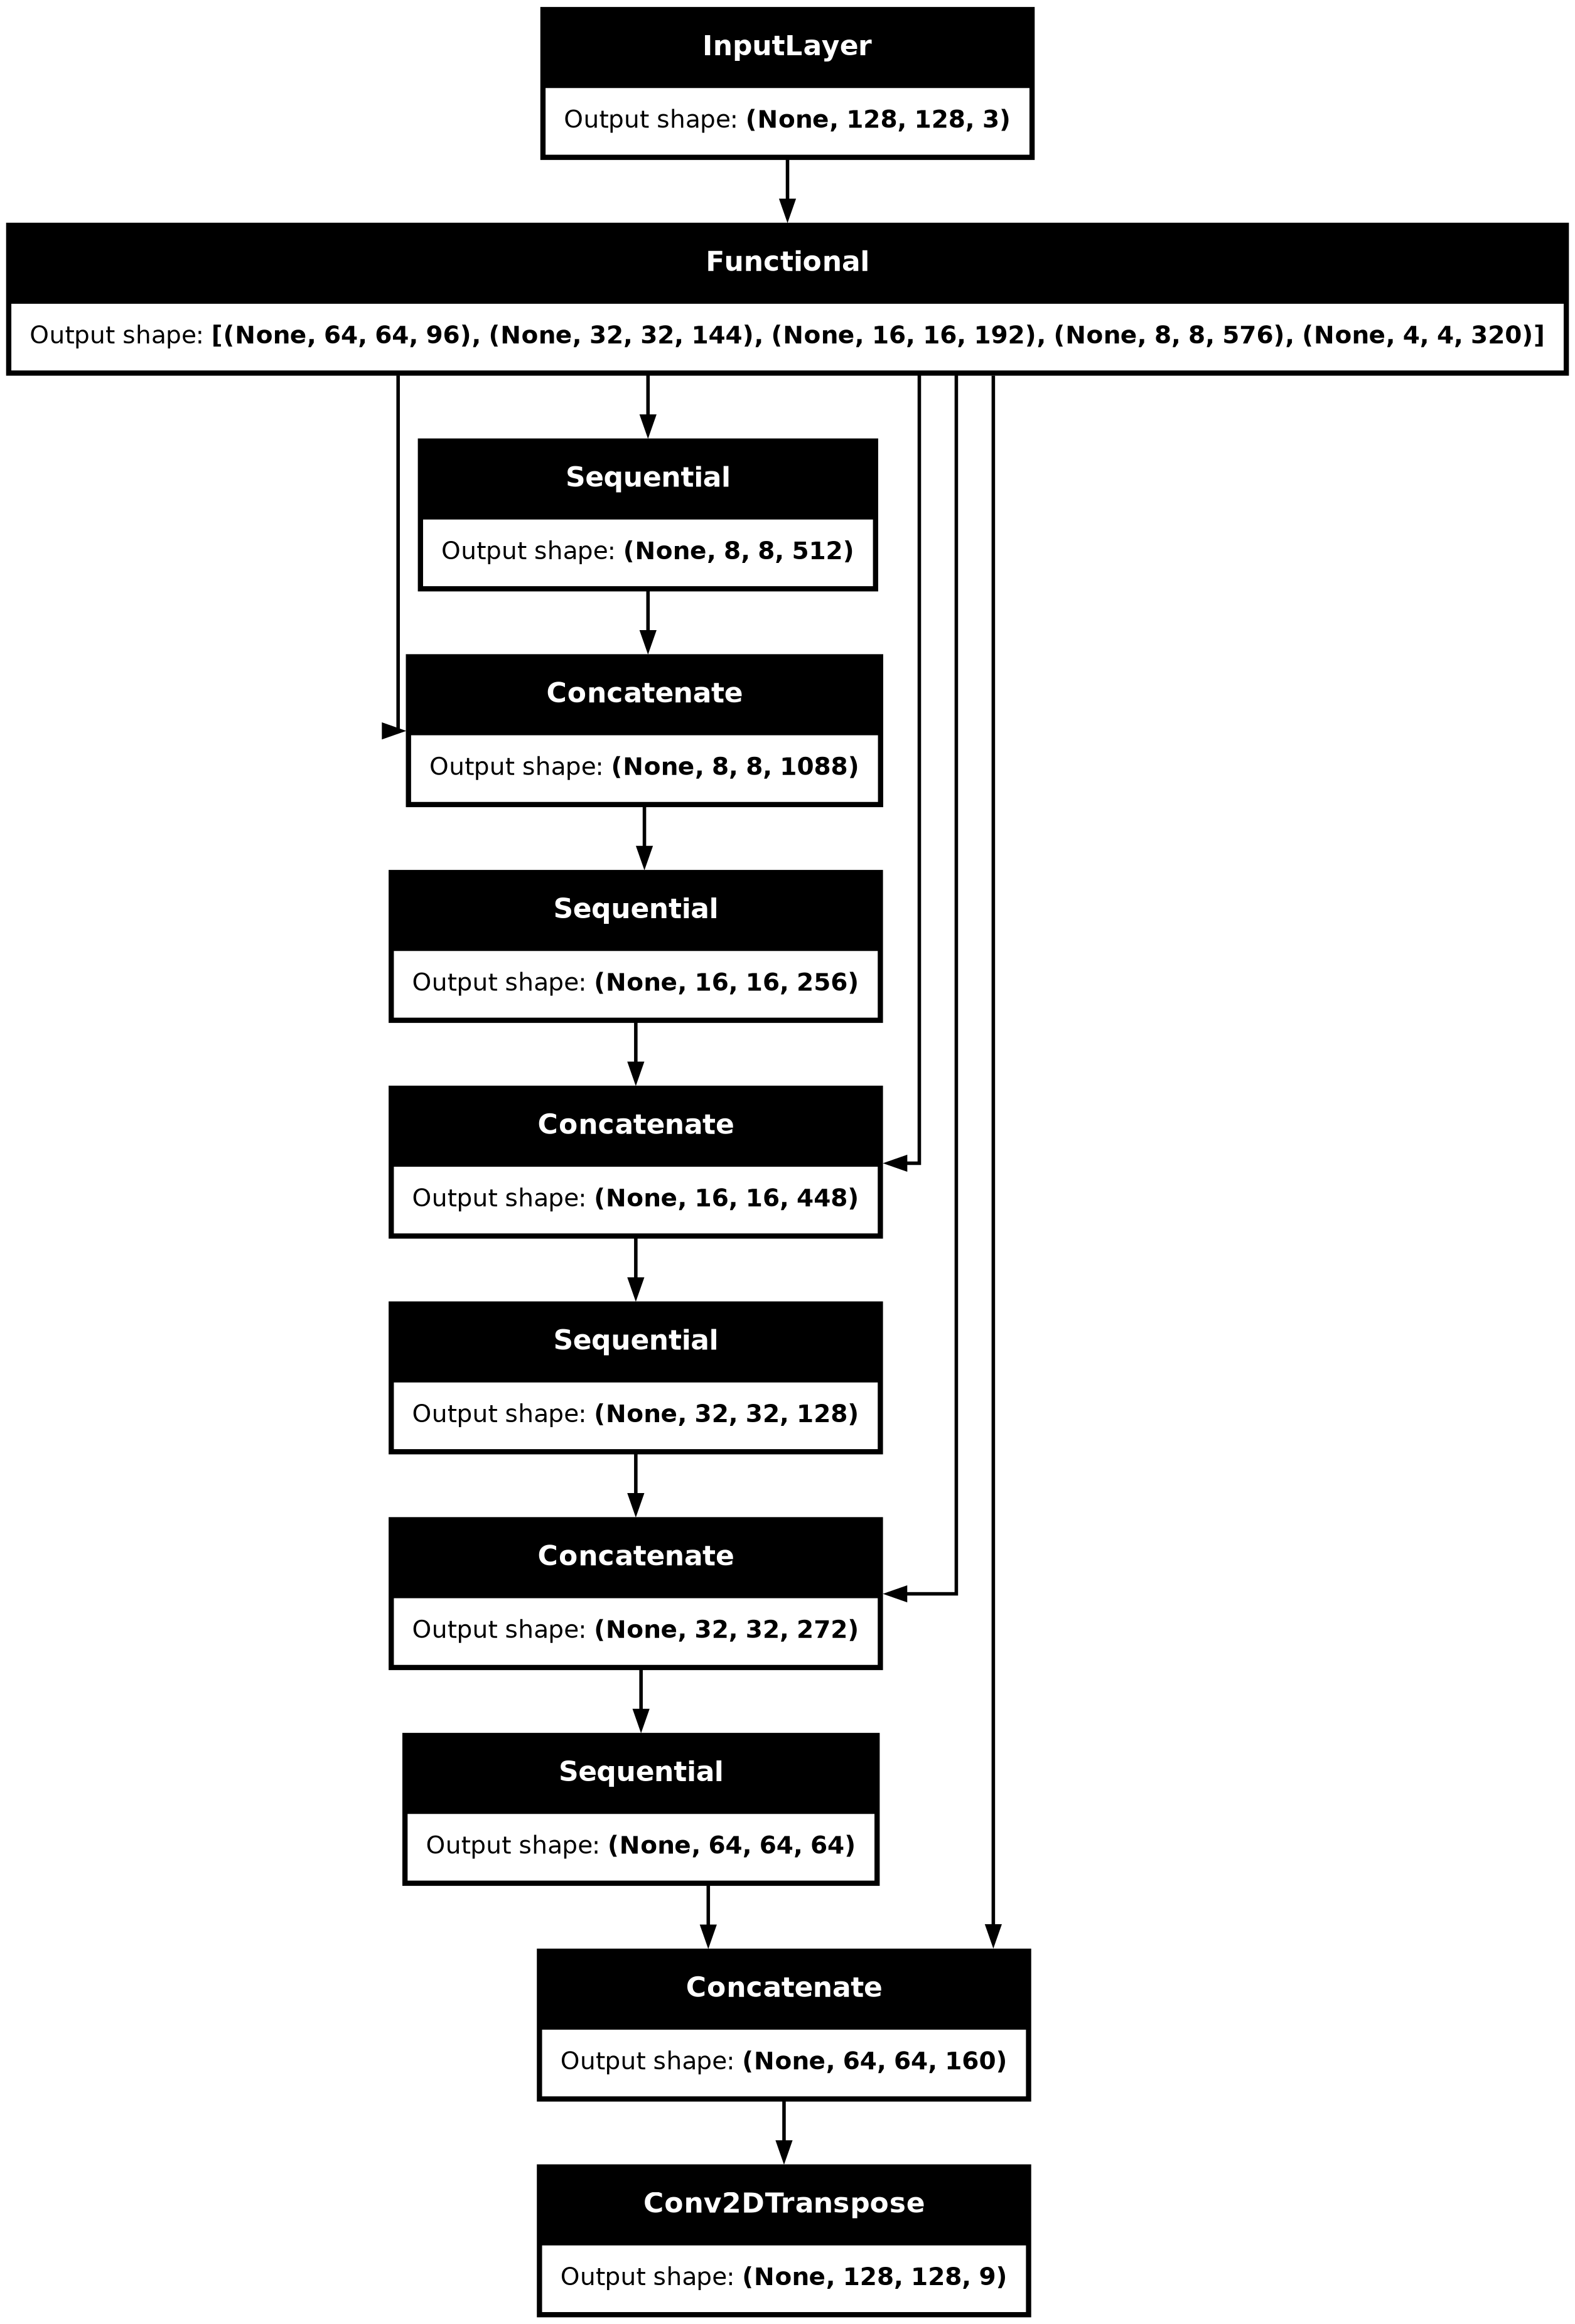

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

# **Configuration of the training parameters and train the model**

In [22]:
#from tensorflow.keras.callbacks import EarlyStopping

TRAIN_LENGTH = 1733 
EPOCHS = 2000
BATCH_SIZE = 64
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = 434//BATCH_SIZE

#train = train.repeat()  # Add .repeat() here to ensure the dataset repeats indefinitely
train, test = preprocessing_data(train_X, test_X, train_y, test_y)

#early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

model_history = model.fit(train, 
                          validation_data=test,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          epochs=EPOCHS,
                          #callbacks=[early_stopping],  # Add early stopping
                          verbose=2)

Epoch 1/2000
27/27 - 5s - 201ms/step - accuracy: 0.8403 - loss: 0.4776 - val_accuracy: 0.8239 - val_loss: 0.5211
Epoch 2/2000
27/27 - 3s - 103ms/step - accuracy: 0.8475 - loss: 0.4587 - val_accuracy: 0.8127 - val_loss: 0.5502
Epoch 3/2000
27/27 - 3s - 112ms/step - accuracy: 0.8316 - loss: 0.5240 - val_accuracy: 0.8292 - val_loss: 0.5178
Epoch 4/2000
27/27 - 3s - 103ms/step - accuracy: 0.7841 - loss: 0.6771 - val_accuracy: 0.8121 - val_loss: 0.5597
Epoch 5/2000
27/27 - 3s - 113ms/step - accuracy: 0.8337 - loss: 0.5089 - val_accuracy: 0.8379 - val_loss: 0.4808
Epoch 6/2000
27/27 - 3s - 103ms/step - accuracy: 0.8366 - loss: 0.4813 - val_accuracy: 0.8247 - val_loss: 0.5070
Epoch 7/2000
27/27 - 3s - 113ms/step - accuracy: 0.8273 - loss: 0.5084 - val_accuracy: 0.8347 - val_loss: 0.4869
Epoch 8/2000
27/27 - 3s - 101ms/step - accuracy: 0.8523 - loss: 0.4314 - val_accuracy: 0.8400 - val_loss: 0.4778
Epoch 9/2000
27/27 - 3s - 114ms/step - accuracy: 0.8662 - loss: 0.3978 - val_accuracy: 0.8514 - 

# **Loss Graph**

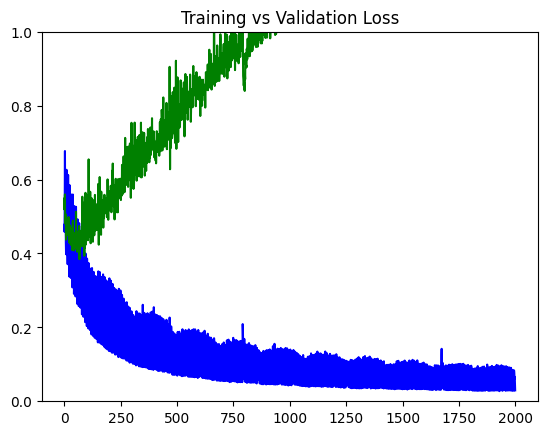

In [23]:
def plot_metrics(metric_name, title, ylim=5):
    '''plots a given metric from the model history'''
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
    plt.plot(model_history.history['val_' + metric_name], color='green',label='val_' + metric_name)

plot_metrics("loss", title="Training vs Validation Loss", ylim=1)

# **Accuracy Graph**

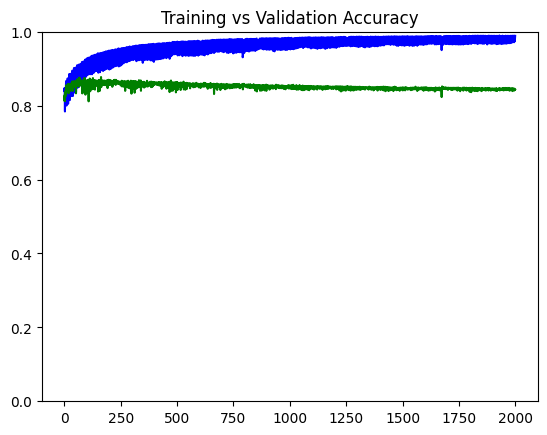

In [24]:
plot_metrics("accuracy", title="Training vs Validation Accuracy", ylim=1)

# **Make prediction and visualize outputs**

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step


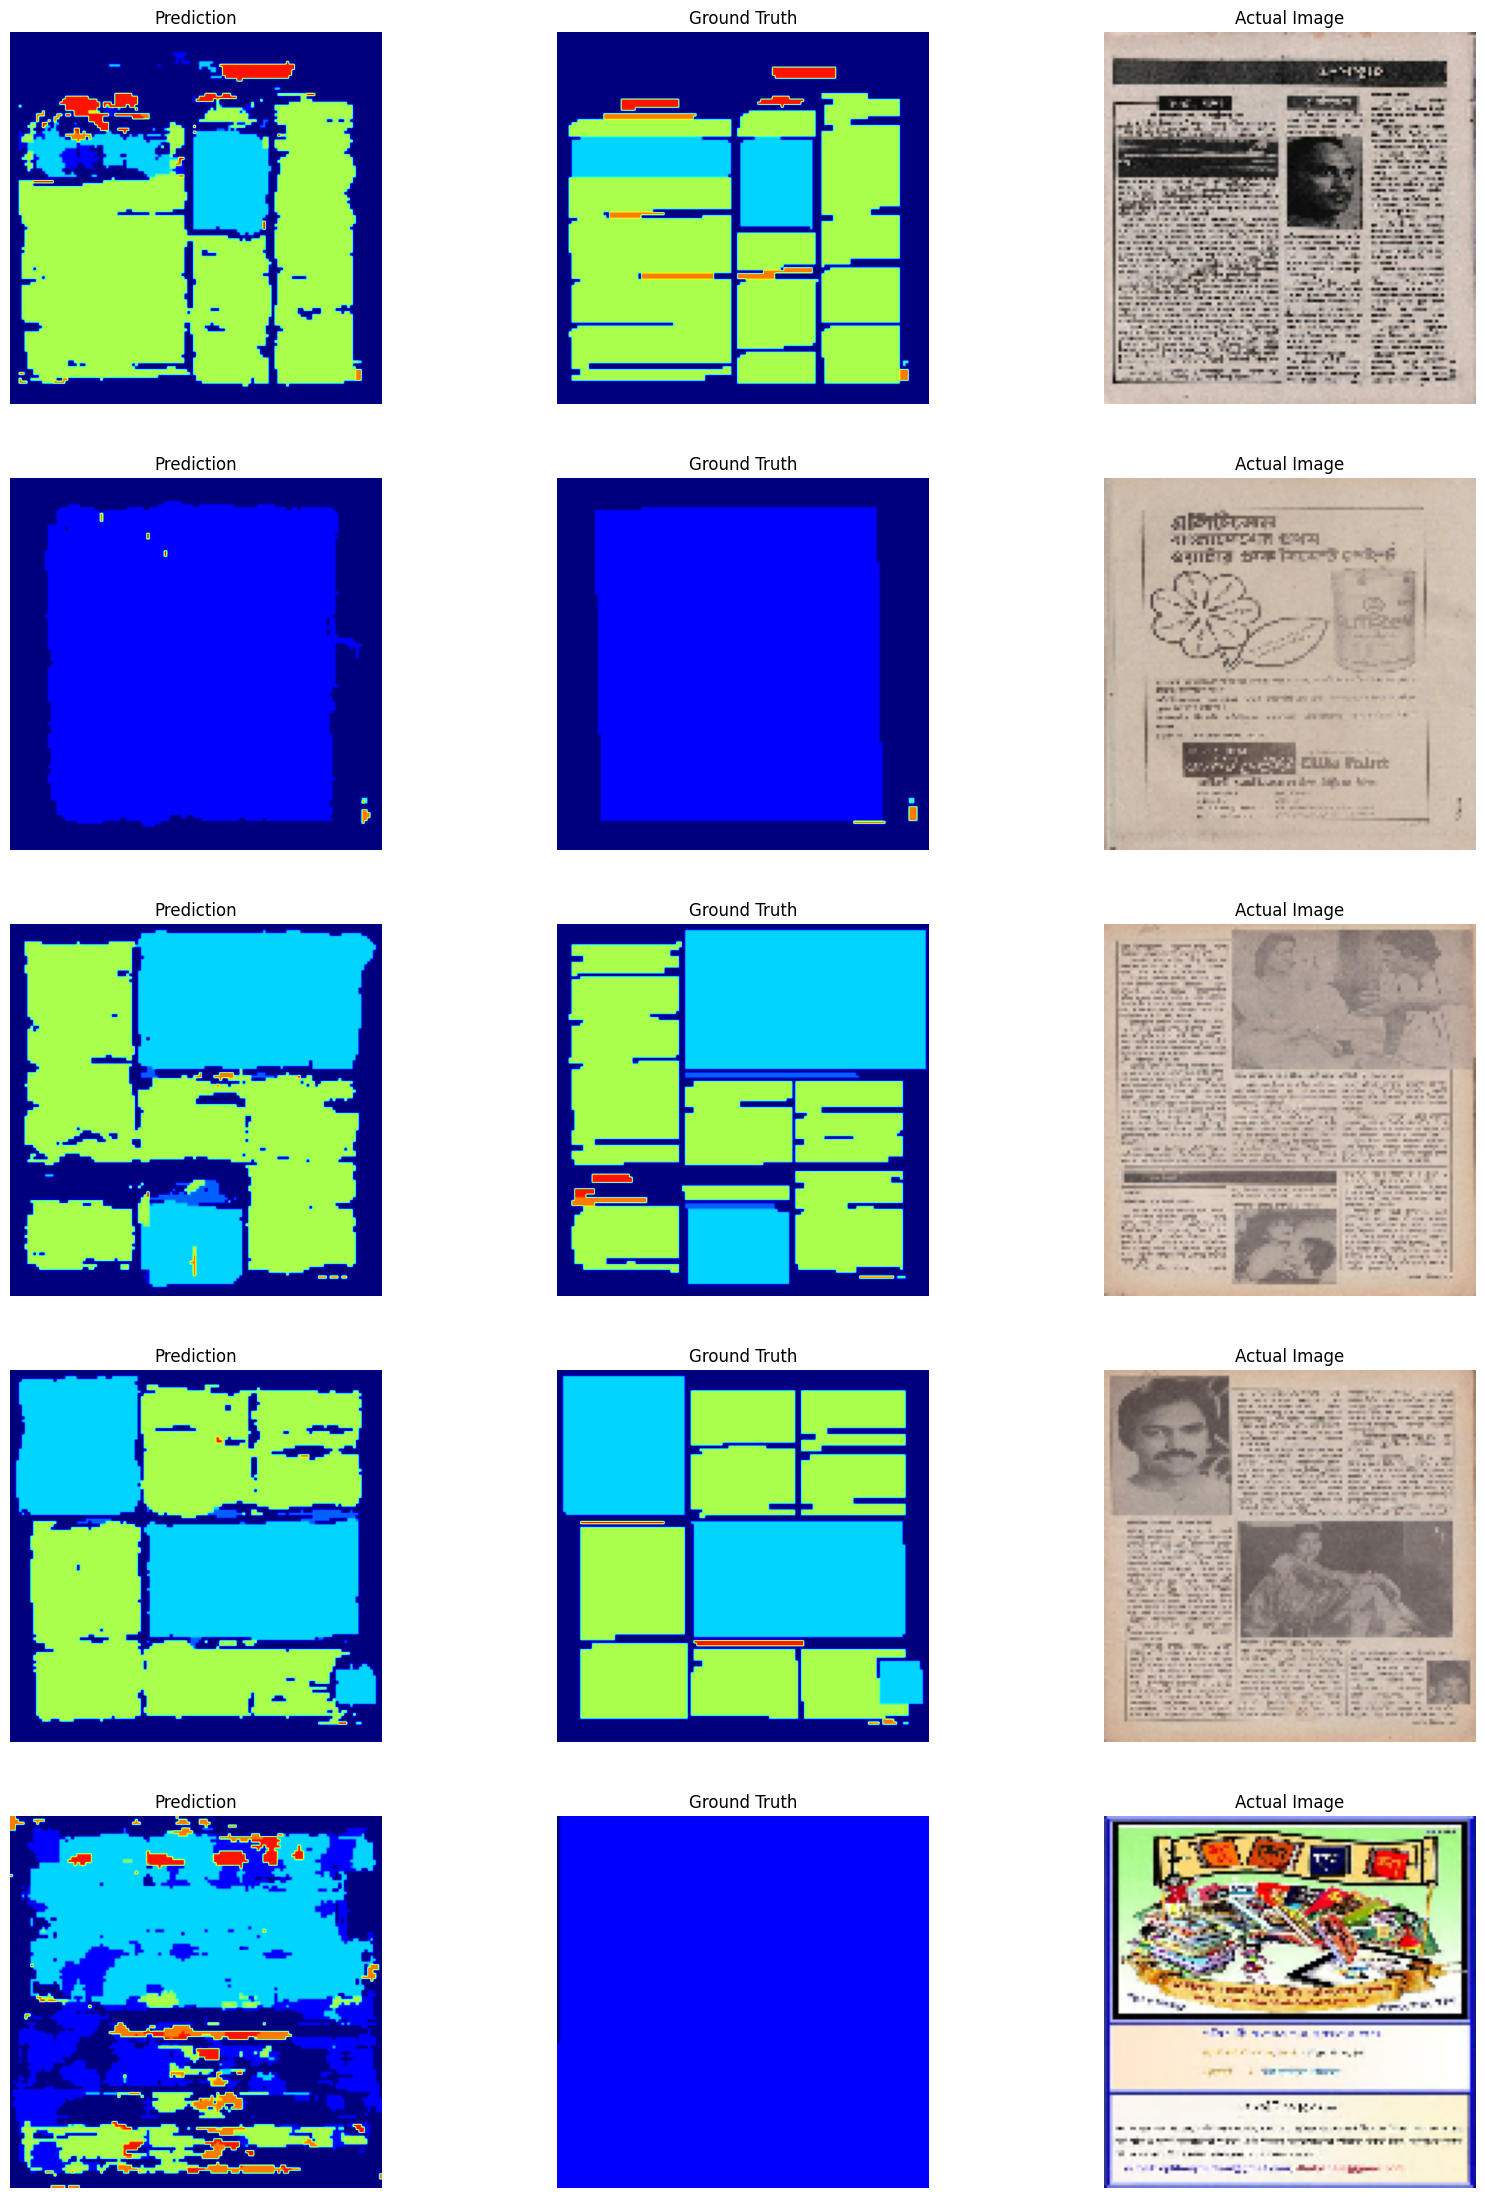

In [25]:
def predict_and_visualize(model, test, num_examples=5):
    img, mask = next(iter(test))
    pred = model.predict(img)
    plt.figure(figsize=(20,28))
    
    for i in range(num_examples):
        # plot the predicted mask
        plt.subplot(num_examples, 3, 1 + i*3)
        predict = tf.argmax(pred[i], axis=-1)
        plt.imshow(predict, cmap='jet', norm=NORM)
        #plt.imshow(predict)
        plt.axis('off')
        plt.title('Prediction')

        # plot the groundtruth mask
        plt.subplot(num_examples, 3, 2 + i*3)
        plt.imshow(mask[i], cmap='jet', norm=NORM)
        #plt.imshow(mask[i])
        plt.axis('off')
        plt.title('Ground Truth')

        # plot the actual image
        plt.subplot(num_examples, 3, 3 + i*3)
        plt.imshow(img[i])
        plt.axis('off')
        plt.title('Actual Image')
    
predict_and_visualize(model, test)

# **Model Evaluation**

For segmentation models,using **intersection-over-union(IOU)** and the **dice score** as metrics to evaluate the model.

### Make Predictions

We can get output segmentation masks by using the `predict()` method. As we may recall, the output of our segmentation model has the shape `(height, width, 9)` where `9` is the number of classes. Each pixel value in those 9 slices indicates the probability of that pixel belonging to that particular class. If we want to create the predicted label map, then you can get the `argmax()` of that axis.

In [26]:
# get the model prediction
results = model.predict(test)

# for each pixel, get the slice number which has the highest probability
results = np.argmax(results, axis=3)
print(results.shape)

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 700ms/step
(434, 128, 128)


# **Compute Metrics**

The function below generates the IOU, Dice score, Precision, Recall of the prediction and ground truth masks. From the lectures, it is given that:

$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
<br>
$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$
<br>
$$Precision = \frac{True\_Positive\_(TP)}{{True\_Positive\_(TP)} + {False\_Positive\_(FP)}}$$
<br>
$$Recall = \frac{True\_Positive\_(TP)}{{True\_Positive\_(TP)} + {False\_Negative\_(FN)}}$$

A small smoothening factor is introduced in the denominators to prevent possible division by zero.

In [27]:
def compute_metrics(y_true, y_pred, num_classes):
    '''
    Computes IOU and Dice Score.

    Args:
        y_true (tensor) - ground truth label map
        y_pred (tensor) - predicted label map
    '''

    class_wise_iou = []
    class_wise_dice_score = []
    class_wise_precision = []
    class_wise_recall = []

    smoothening_factor = 0.00001
    y_true_reshape = np.reshape(y_true, y_pred.shape)

    for i in range(num_classes):
        intersection = np.sum((y_pred == i) * (y_true_reshape == i))
        y_true_area = np.sum(y_true_reshape == i)
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area

        # Calculate iou
        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)
        
        # Calculate dice score
        dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)
        
        # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
        true_positives = np.sum((y_pred == i) & (y_true_reshape == i))
        false_positives = np.sum((y_pred == i) & (y_true_reshape != i))
        false_negatives = np.sum((y_pred != i) & (y_true_reshape == i))
        
        # Calculate precision
        precision = true_positives / (true_positives + false_positives + smoothening_factor)
        class_wise_precision.append(precision)
        
        # Calculate recall
        recall = true_positives / (true_positives + false_negatives + smoothening_factor)
        class_wise_recall.append(recall)
    
    return class_wise_iou, class_wise_dice_score, class_wise_precision, class_wise_recall

# **Class Labels from csv file**

In [28]:
import pandas as pd
csv_file = pd.read_csv('/kaggle/input/fydp-u-net-model-dataset/FYDP_U_NET/labels.csv')
class_names = list(tuple(csv_file['label_list']))
class_names[0] = 'background'

# **Compute class-wise metrics**

In [29]:
cls_wise_iou, cls_wise_dice_score, cls_wise_precision, cls_wise_recall = compute_metrics(test_y, results, len(class_names))

# **Print the IOU score for each class**

In [30]:
for idx, iou in enumerate(cls_wise_iou):
    spaces = ' ' * (13-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, iou)) 

background     0.7688846265676681 
advertisement  0.5829676120584725 
caption        0.09149580241832891 
image          0.7306952703191992 
page number    0.16245831547770767 
paragraph      0.8088983866345653 
table          0.4811376337254167 
text           0.18296118720619456 
title          0.31960071934239054 


# **Print the Dice score for each class**

In [31]:
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score))

background     0.869344009237063 
advertisement  0.7365502713027008 
caption        0.16765213799182352 
image          0.8443950623237727 
page number    0.2795082002469094 
paragraph      0.8943546996482593 
table          0.6496865960312388 
text           0.30932745587676846 
title          0.4843900350697546 


# **Print the Precision score for each class**

In [32]:
for idx, precision in enumerate(cls_wise_precision):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, precision))

background     0.8503940464374133 
advertisement  0.7362280945655602 
caption        0.3400191018359131 
image          0.849180119479169 
page number    0.41585365600089236 
paragraph      0.8952807871151062 
table          0.7587313652380123 
text           0.37876070923603744 
title          0.6031108463270806 


# **Print the Recall score for each class**

In [33]:
for idx, recall in enumerate(cls_wise_recall):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, recall))

background     0.8891577729648139 
advertisement  0.7368727300971661 
caption        0.11125386294272237 
image          0.8396636297478101 
page number    0.21049382651082152 
paragraph      0.8934305260970172 
table          0.5680469630420574 
text           0.2614071055002366 
title          0.4047216283665097 


In [ ]:
#print("Overall Recall:", overall_recall)